# American Express

- 월별 고객 프로필 바탕으로 고객이 향후 신용카드 잔액을 갚지 않을 확률을 예측하는 것

D* = Delinquency variables 연체

S = Spend variables 소비

P_ = Payment variables 지불

B* = Balance variables 잔고

R* = Risk variables 위험

Following features are categorical: B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126.

S_2: contains a timestamp

### 참고

코드 

1) https://www.kaggle.com/code/ambrosm/amex-eda-which-makes-sense

2) https://www.kaggle.com/code/datark1/american-express-eda


데이터 파일 관련 

https://www.kaggle.com/code/datark1/american-express-eda/data?select=test_data.ftr

train_data.csv - training data with multiple statement dates per customer_ID

train_labels.csv - target label for each customer_ID

test_data.csv - corresponding test data; objective is to predict the target label for each customer_ID

sample_submission.csv - a sample submission file in the correct forma

지난주에 sample만 시도했어서 이번에는 test train 돌려봄 

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import math
import gc
import pprint

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## TRAIN_DATA / TEST_DATA

데이터가 너무 커서 덩어리로 나눠 보거나 아니면 ftr 파일로 볼 수 있는데 아래는 ftr로 확인한 경우

In [4]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [6]:
# %%time 지난번 코드를 돌릴 때는 원만하게 나왔는데 이번엔 time 하면 잘 나오지 않음
train = pd.read_feather('train_data.ftr')
test = pd.read_feather('test_data.ftr')
with pd.option_context("display.min_rows", 6):
    display(train)
    display(test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,0.016357,0.401611,0.091064,CR,O,0.007126,0.007664,NaN,0.652832,0.008522,NaN,0.004730,6.0,0.271973,0.008362,0.515137,0.002644,0.009010,0.004807,0.008339,0.119385,0.004803,0.108276,0.050873,NaN,0.007553,0.080444,0.069092,NaN,0.004326,0.007561,NaN,0.007729,0.000272,0.001575,0.004238,0.001434,NaN,0.002272,0.004059,0.007122,0.002457,0.002310,0.003532,0.506836,0.008034,1.009766,0.084656,0.003820,0.007042,0.000438,0.006451,0.000830,0.005054,NaN,0.0,0.005722,0.007084,NaN,0.000198,0.008911,NaN,1.0,0.002537,0.005177,0.006626,0.009705,0.007782,0.002449,1.000977,0.002665,0.007481,0.006893,1.503906,1.005859,0.003569,0.008873,0.003948,0.003647,0.004951,0.894043,0.135620,0.911133,0.974609,0.001244,0.766602,1.008789,1.004883,0.893555,NaN,0.669922,0.009972,0.004570,NaN,1.008789,2.0,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1.0,0.238281,0.0,4.0,0.232178,0.236206,0.0,0.702148,0.434326,0.003057,0.686523,0.008743,1.0,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,0.017685,0.406250,0.086792,CR,O,0.002413,0.007149,NaN,0.646973,0.002237,NaN,0.003880,6.0,0.188965,0.004028,0.509277,0.004192,0.007843,0.001283,0.006523,0.140625,0.000094,0.101013,0.040466,NaN,0.004833,0.081421,0.074158,NaN,0.004204,0.005302,NaN,0.001864,0.000978,0.009895,0.007599,0.000509,NaN,0.009811,0.000126,0.005966,0.000395,0.001327,0.007774,0.500977,0.000761,1.009766,0.081848,0.000347,0.007790,0.004311,0.002333,0.009468,0.003754,NaN,0.0,0.007584,0.006676,NaN,0.001143,0.005905,NaN,1.0,0.008430,0.008980,0.001854,0.009926,0.005989,0.002247,1.006836,0.002508,0.006828,0.002836,1.503906,1.005859,0.000571,0.000391,0.008354,0.008850,0.003180,0.902344,0.136353,0.919922,0.975586,0.004562,0.786133,1.000000,1.003906,0.906738,NaN,0.668457,0.003922,0.004654,NaN,1.002930,2.0,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1.0,0.247192,0.0,4.0,0.243530,0.241943,0.0,0.707031,0.430420,0.001306,0.686523,0.000755,1.0,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,0.113159,NaN,0.007584,0.116394,0.004482,0.009514,0.005177,NaN,0.474365,0.626465,NaN,0.174561,1.250977,1.003906,NaN,0.008720,0.001013,0.103577,0.119019,NaN,-0.002918,NaN,0.002771,0.004417,1.006836,1.004883,0.002810,0.105591,0.119202,0.321777,0.114563,NaN,NaN,0.003420,0.205933,NaN,0.010185,NaN,0.027466,0.588867,0.010490,1.881836,0.051819,CR,,0.008293,0.008667,NaN,0.592285,0.009148,NaN,0.004986,NaN,0.190552,0.002676,0.409424,0.009987,NaN,0.005211,NaN,0.014687,0.004311,0.400635,1.134766,0.178833,0.959473,0.217651,0.204590,NaN,0.009796,0.007748,0.002916,0.006897,0.001657,0.004356,NaN,0.002008,NaN,0.002531,0.000348,0.001173,0.004169,0.004585,0.002291,0.508301,0.005093,1.002930,0.133789,0.004322,NaN,0.008858,0.004143,0.009560,0.006943,NaN,0.0,0.003683,0.009911,NaN,0.008911,0.002954,NaN,1.0,0.009003,0.003418,0.002201,0.003780,0.002949,0.004635,1.003906,0.006653,0.007473,0.000192,NaN,0.008759,0.000834,0.004391,0.004116,0.008446,0.009575,0.980957,0.134888,0.954590,0.971191,0.006561,0.002419,NaN,NaN,NaN,NaN,NaN,0.008148,0.007973,NaN,NaN,1.0,NaN,0.005123,NaN,NaN,NaN,1.003906,0.274170,0.004303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.006203,NaN,NaN,0.009666,NaN,NaN,NaN,NaN,0.007080,0.005959,NaN,NaN,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,0.123047,NaN,0.006645,0.134888,0.009499,0.026306,0.009026,NaN,0.473633,0.611816,NaN,0.177124,0.234131,1.009766,NaN,0.003145,0.005535,0.101257,0.120972,NaN,0.031219,NaN,0.006496,0.010002,1.005859,1.000000,0.000525,0.160522,0.121460,0.170776,0.184082,NaN,0.028351,0.007156,0.403320,0.014488,0.025131,NaN,0.054779,0.623047,0.021698,2.042969,0.057556,CR,,0.002012,0.000835,NaN,0.590820,0.000165,NaN,0.001556,NaN,0.190186,0.001771,0.561523,0.008125,NaN,0.008392,0.000606,0.011948,0.002283,0.605957,0.208374,0.179443,0.961426,0.216553,0.206543,NaN,0.004547,0.003098,NaN,0.003681,0.005516,0.001506,0.001014,0.006443,NaN,0.007168,0.003077,0.005878,0.004055,0.009636,0.001225,0.508789,0.007320,1.003906,0.144653,0.005299,NaN,0.001477,0.002083,0.002234,0.005524,NaN,0.0,0.006409,0.007458,NaN,0.000843,0.007458,NaN,1.0,0.005119,0.002382,0.006557,0.001691,0.004448,0.000575,1.004883,0.004395,0.001168,0.006695,NaN,0.004318,0.008072,0.007889,0.007656,0.006348,0.006950,0.966797,0.138550,0.957031,0.975098,0.004612,0.006550,0.003031,0.008759,NaN,NaN,0.004696,0.000078,0.015465,NaN,1.007812,1.0,NaN,0.000610,NaN,NaN,NaN,1.004883,0.353760,0.276611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.003834,0.008781,0.005577,0.007442,NaN,0.007599,0.008072,NaN,0.007187,0.001253,NaN,NaN,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,0.1

In [7]:
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

In [8]:
train.shape

(5531451, 191)

In [9]:
train.isnull().sum().sort_values(ascending=False) # 결측값 확인을 위함 

D_87      5527586
D_88      5525447
D_108     5502513
D_111     5500117
D_110     5500117
           ...   
D_75            0
P_4             0
B_23            0
S_15            0
target          0
Length: 191, dtype: int64

범주형 변수확인 

데이터가 정말.. 많음 

결측값있는 행/열이 많은데 모두 드랍한다고 좋은 전략으로 보이진 않음 -> 의사 결정 트리 기반 알고리즘은 결측값 처리 가능

원본 csv가 아니라 용량때문에 ftr 파일을 사용해 비트 반올림을 하면서 정보 손실이 우려되고 이것때문에 결측값이 많이 나타나는 듯
더 높은 정밀도가 필요해보임


- 의사 결정 트리 기반 알고리즘 LGBM

Light GBM은 Kaggle 데이터 분석 경진대회에서 우승한 많은 Tree기반 머신러닝 알고리즘에서 XGBoost와 함께 사용되어진 것이 알려지며 더욱 유명

Tree 기반 학습 알고리즘 (Leaf-wise)

다른 Tree 기반 알고리즘과 달리 Tree구조가 수직적으로 확장한다.

Leaf-wise는 속도가 빠르다는 것이 가장 큰 장점이다. Light GBM은 큰 사이즈의 데이터를 다룰 수 있고 실행시킬 때 적은 메모리를 차지한다.


In [10]:
train['S_2'] = pd.to_datetime(train['S_2'])
train['S_2'] # 시간에 대해 나타내는 변수

0         2017-03-09
1         2017-04-07
2         2017-05-28
3         2017-06-13
4         2017-07-16
             ...    
5531446   2017-11-05
5531447   2017-12-23
5531448   2018-01-06
5531449   2018-02-06
5531450   2018-03-14
Name: S_2, Length: 5531451, dtype: datetime64[ns]

시간 확인: 2017.03.09-2018.03.14

In [22]:
# 효율적으로 보려면 이 코드 -> 기간이 겹치지 않는 것을 확인
print(f'Train dates range is from {train["S_2"].min()} to {train["S_2"].max()}.')
print(f'Test dates range is from {test["S_2"].min()} to {test["S_2"].max()}.')

Train dates range is from 2017-03-01 00:00:00 to 2018-03-31 00:00:00.
Test dates range is from 2018-04-01 00:00:00 to 2019-10-31 00:00:00.


In [46]:
# 범주형
categorical_features = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
train[categorical_features] = train[categorical_features].astype("category")
train[categorical_features].dtypes

B_30     category
B_38     category
D_63     category
D_64     category
D_66     category
D_68     category
D_114    category
D_116    category
D_117    category
D_120    category
D_126    category
dtype: object

In [56]:
train[categorical_features].sample(10) # 범주형 변수들에 대해 확인

,B_30,B_38,D_63,D_64,D_66,D_68,D_114,D_116,D_117,D_120,D_126
2348060,0.0,3.0,CO,R,NaN,4.0,0.0,0.0,-1.0,0.0,0.0
2956814,0.0,3.0,CO,R,NaN,5.0,1.0,0.0,4.0,0.0,1.0
1698152,0.0,3.0,CO,O,NaN,6.0,0.0,0.0,2.0,0.0,1.0
4119269,0.0,1.0,CO,O,NaN,6.0,1.0,0.0,-1.0,0.0,1.0
2766913,1.0,6.0,CO,O,NaN,6.0,1.0,0.0,2.0,0.0,0.0
874744,0.0,3.0,CO,R,1.0,3.0,0.0,0.0,-1.0,0.0,0.0
4292209,2.0,5.0,CO,R,NaN,6.0,1.0,0.0,3.0,1.0,1.0
4931477,0.0,1.0,CO,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5491795,0.0,3.0,CO,O,1.0,6.0,0.0,0.0,4.0,0.0,1.0
5183786,0.0,5.0,CL,O,NaN,6.0,1.0,0.0,4.0,0.0,1.0


In [57]:
for cf in categorical_features:
    print(cf, list(train[cf].unique()))

B_30 [0.0, 2.0, 1.0, nan]
B_38 [2.0, 1.0, 3.0, 5.0, 6.0, 7.0, 4.0, nan]
D_63 ['CR', 'CO', 'CL', 'XZ', 'XM', 'XL']
D_64 ['O', 'R', '', 'U', '-1']
D_66 [nan, 1.0, 0.0]
D_68 [6.0, 2.0, 3.0, nan, 5.0, 4.0, 0.0, 1.0]
D_114 [1.0, 0.0, nan]
D_116 [0.0, nan, 1.0]
D_117 [4.0, -1.0, 6.0, 2.0, 1.0, nan, 3.0, 5.0]
D_120 [0.0, 1.0, nan]
D_126 [1.0, nan, 0.0, -1.0]


In [50]:
train[categorical_features].isna().sum().div(len(train)).sort_values(ascending=False)

D_66     0.887307
D_68     0.039140
D_114    0.031947
D_116    0.031947
D_117    0.031947
D_120    0.031947
D_126    0.021119
B_30     0.000364
B_38     0.000364
D_63     0.000000
D_64     0.000000
dtype: float64

원래 NAN이 뜨면 안되고.. 결측치도 0여야 맞는건데.. 왜 난 뭐가 잘못된거지

In [18]:
tmp = train.isna().sum().div(len(train)).mul(100).sort_values(ascending=False)
tmp

D_87      99.930127
D_88      99.891457
D_108     99.476846
D_111     99.433530
D_110     99.433530
            ...    
D_75       0.000000
P_4        0.000000
B_23       0.000000
S_15       0.000000
target     0.000000
Length: 191, dtype: float64

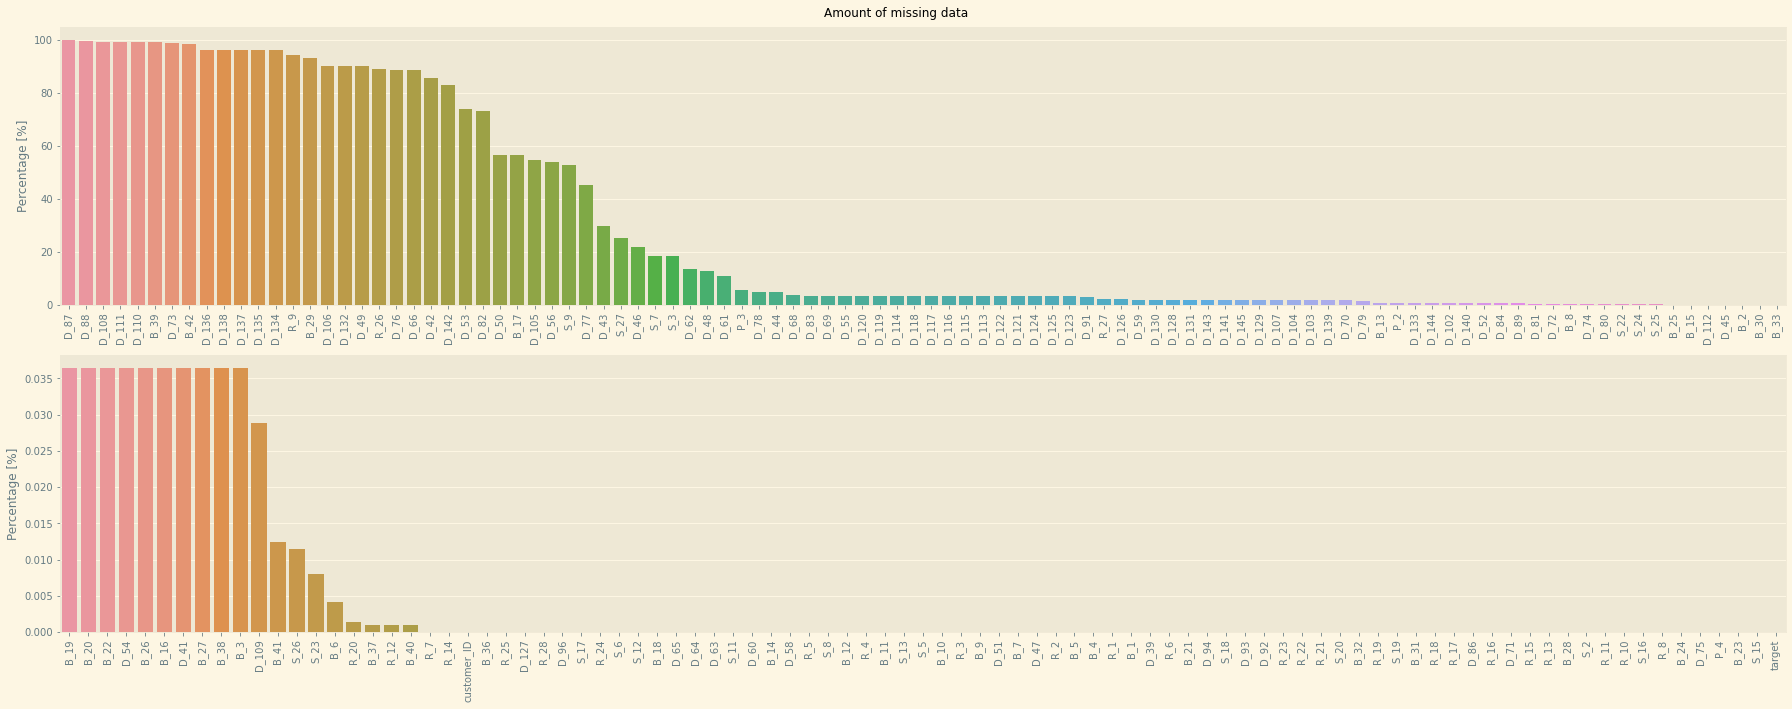

In [19]:
# tmp 자료 시각화
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(2,1, figsize=(25,10))
sns.barplot(x=tmp[:100].index, y=tmp[:100].values, ax=ax[0])
sns.barplot(x=tmp[100:].index, y=tmp[100:].values, ax=ax[1])
ax[0].set_ylabel("Percentage [%]"), ax[1].set_ylabel("Percentage [%]")
ax[0].tick_params(axis='x', rotation=90); ax[1].tick_params(axis='x', rotation=90)
plt.suptitle("Amount of missing data")
plt.tight_layout()
plt.show()

# 상당히 많은 결측치 확인가능

In [20]:
# 타겟 변수의 분포확인을 위함

tmp = train['target'].value_counts().div(len(train)).mul(100)

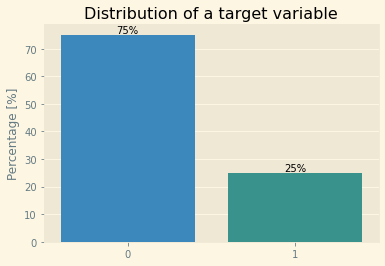

In [21]:
ax = sns.barplot(x=tmp.index, y=tmp.values)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")
plt.show()

# 데이터셋이 불균형하다는 의미이며 25%의 고객이 채무 불이행. 
# 이 두 그룹을 별도로 조사하여 차이점 확인 
# 먼저 얼마나 많은 고유 고객이 있는지 확인

In [23]:
# 고유한 고객의 수, 우리는 약 459000명의 고유한 고객들을 보유
# train_labels 을 확인해보면 같은 것을 확인
print(f'Number of unique customers: {train["customer_ID"].nunique()}')

Number of unique customers: 458913


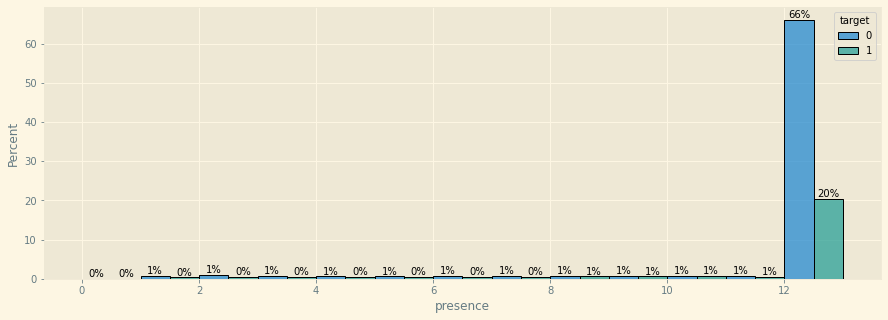

In [26]:
cust_presence = train.groupby(['customer_ID','target']).size().reset_index().rename(columns={0:'presence'})

fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.f%%')
ax.bar_label(ax.containers[1], fmt='%.f%%')
plt.show()

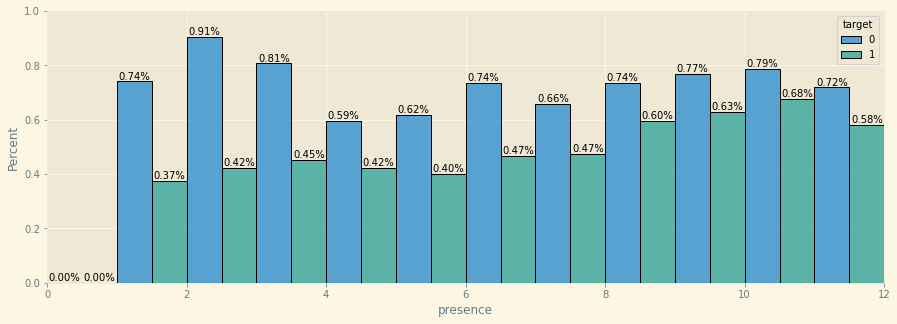

In [27]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.bar_label(ax.containers[1], fmt='%.2f%%')
ax.set_xlim(0,12)
ax.set_ylim(0,1)
plt.show()

위의 그림은 데이터 세트에 고객이 존재하는 기간을 보여 줍니다. 그것은 그들 중 93%가 일년 내내 볼 수 있다는 것을 보여준다. 

이 그래프에서는 나머지 고객에 대한 타겟이 어떻게 분포되어 있는지 확인하기 어려우니 확대한 것

13개 미만인 고객이 누구인지 확인 필요

기간이 짧을수록 0비율이 높아짐

In [28]:
# 13개 미만인 고객이 누구인지 확인 필요

short_customer_ids = list(cust_presence[cust_presence['presence']<13]['customer_ID'])
gc.collect()

52114

In [30]:
short_customers = train[train['customer_ID'].isin(short_customer_ids)][['customer_ID','S_2']]
short_customers['month'] = short_customers['S_2'].dt.month
short_customers['year'] = short_customers['S_2'].dt.year
short_customers.groupby(['year','month']).size()

year  month
2017  3         9596
      4        15522
      5        14272
      6        24350
      7        29568
      8        35065
      9        39421
      10       44258
      11       48234
      12       52876
2018  1        60221
      2        66747
      3        72879
dtype: int64

In [31]:
len(short_customers)

513009

만약에 모든 short customer이 늦게 가입한 경우 동일한 번호를 가진 모든 고객이 같은 달에 있다?

In [32]:
n=2
short_customer_ids_n = list(cust_presence[cust_presence['presence']<=n]['customer_ID'])

short_customers = train[train['customer_ID'].isin(short_customer_ids_n)][['customer_ID','S_2']]
short_customers['month'] = short_customers['S_2'].dt.month
short_customers['year'] = short_customers['S_2'].dt.year
print(f"Customers with presence equal to {n} observations.")
print(short_customers.groupby(['year','month']).size())

Customers with presence equal to 2 observations.
year  month
2017  3           27
      4           11
      5            4
      6            6
      7            2
      8            6
      9            1
      10           3
      11           2
      12           9
2018  1          271
      2         5756
      3        11218
dtype: int64



short customers은  관측에서 드롭된 경우이다.

모범적인 고객들에 대한 서브샘플데이터 아래에서 확인

In [34]:
cust_2obs_03_2017 = list(short_customers.loc[(short_customers['year']==2017)&(short_customers['month']==3),'customer_ID'])
sample_customer = np.random.choice(cust_2obs_03_2017)
train[train["customer_ID"]==sample_customer].head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
1477634,440f7ebd1481d284b32d952643a524253e42696b821f8f...,2017-03-30,NaN,0.007076,0.009735,0.275391,0.000866,0.195068,0.001662,0.093384,NaN,NaN,0.005436,0.003286,0.096619,0.005398,0.004753,NaN,0.247192,0.226685,NaN,0.180908,0.002150,1.005859,NaN,0.001152,0.327881,0.002632,0.158813,NaN,0.087097,NaN,0.004757,0.004501,1.009766,1.000977,0.003193,0.155396,0.017715,0.127197,0.040344,NaN,0.086853,0.002008,0.006191,NaN,0.003622,NaN,1.001953,NaN,0.003336,0.484619,NaN,CO,,0.007820,1.000977,0.009750,1.000977,0.009895,NaN,0.824707,NaN,0.187134,0.008064,0.006458,0.005535,NaN,0.005981,NaN,0.012413,0.005291,0.401367,0.001684,NaN,0.000485,NaN,0.076599,NaN,0.009560,0.003078,NaN,0.004887,0.009636,0.003307,NaN,0.003847,NaN,0.002941,NaN,0.002392,0.001669,0.008163,0.006115,NaN,0.004944,1.008789,0.005230,0.001422,NaN,0.007519,0.004410,0.005806,0.002390,NaN,0.0,0.008186,0.001852,NaN,0.007240,0.002106,NaN,1.0,0.007889,0.002558,0.009155,0.003948,0.002546,0.000944,0.007191,0.006878,0.009338,0.004501,NaN,0.004482,0.007610,0.005192,0.009331,0.002285,0.006721,NaN,0.137085,NaN,0.970215,0.002703,NaN,NaN,NaN,NaN,NaN,NaN,0.002531,0.003344,NaN,NaN,3.0,NaN,0.009583,NaN,NaN,NaN,1.009766,0.006294,NaN,0.009003,0.0,0.002335,0.0,-1.0,0.009506,0.005226,0.0,-0.026047,0.00206,0.004868,-0.03653,0.001119,-1.0,1.007812,NaN,NaN,0.008934,NaN,NaN,NaN,NaN,NaN,0.007996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1477635,440f7ebd1481d284b32d952643a524253e42696b821f8f...,2018-03-21,NaN,0.000040,0.003672,0.272949,0.006538,0.174683,0.004807,0.097351,NaN,NaN,NaN,0.009727,0.097534,0.001670,0.005943,NaN,0.050323,NaN,NaN,0.042236,0.001402,1.006836,NaN,0.000682,0.324951,0.002583,NaN,NaN,0.087402,NaN,0.003683,0.004982,1.009766,1.000977,0.001941,0.149292,0.006340,0.126099,NaN,NaN,0.095032,0.001897,0.007050,NaN,0.000908,NaN,1.007812,NaN,0.001251,0.481689,NaN,CO,,0.001552,1.002930,0.001698,1.002930,0.004295,NaN,0.829590,NaN,0.193481,0.002050,0.003136,0.007767,NaN,0.006210,NaN,0.008224,NaN,0.404541,0.000349,NaN,0.003389,NaN,0.070312,NaN,0.003492,0.007504,NaN,0.000770,0.002522,NaN,NaN,0.009842,NaN,0.004978,NaN,0.006439,0.003830,0.001713,NaN,NaN,0.002890,1.006836,0.009094,0.008240,NaN,0.009354,0.008423,NaN,0.003628,NaN,0.0,0.006500,0.005020,NaN,0.007229,0.002193,NaN,1.0,0.008545,0.001801,0.004475,0.001565,0.003307,0.009125,0.001887,NaN,0.006378,0.000365,NaN,0.005295,0.001951,0.007381,0.003527,0.003397,0.002892,NaN,0.135254,NaN,0.971191,0.002258,0.006683,NaN,NaN,NaN,NaN,NaN,0.000229,0.001845,NaN,NaN,3.0,NaN,0.003330,NaN,NaN,NaN,1.002930,0.005154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000299,NaN,NaN,0.003191,NaN,NaN,NaN,NaN,0.004967,0.007442,NaN,NaN,NaN,NaN,NaN,NaN,0.001096,NaN,NaN,NaN,0.001299,NaN,0


### 상관관계

전체 상관 행렬을 계산하는 데 시간이 걸리기 때문에 25%의 고객 표본을 사용

In [35]:
def sample_full_cust(df, cust_ratio):
    n_customers = df['customer_ID'].nunique()
    no_of_cust = int(n_customers*cust_ratio)
    cust_ids = np.random.choice(df['customer_ID'].unique(), no_of_cust)
    print(f'Number of customers sampled: {no_of_cust}')
    ready_df = df[df['customer_ID'].isin(cust_ids)]
    print(f'Number of rows sampled: {len(ready_df)} ({round(len(ready_df)/len(df)*100)}%)')
    return ready_df

In [37]:
train_samples = sample_full_cust(train, 0.55)

Number of customers sampled: 252402
Number of rows sampled: 2339479 (42%)


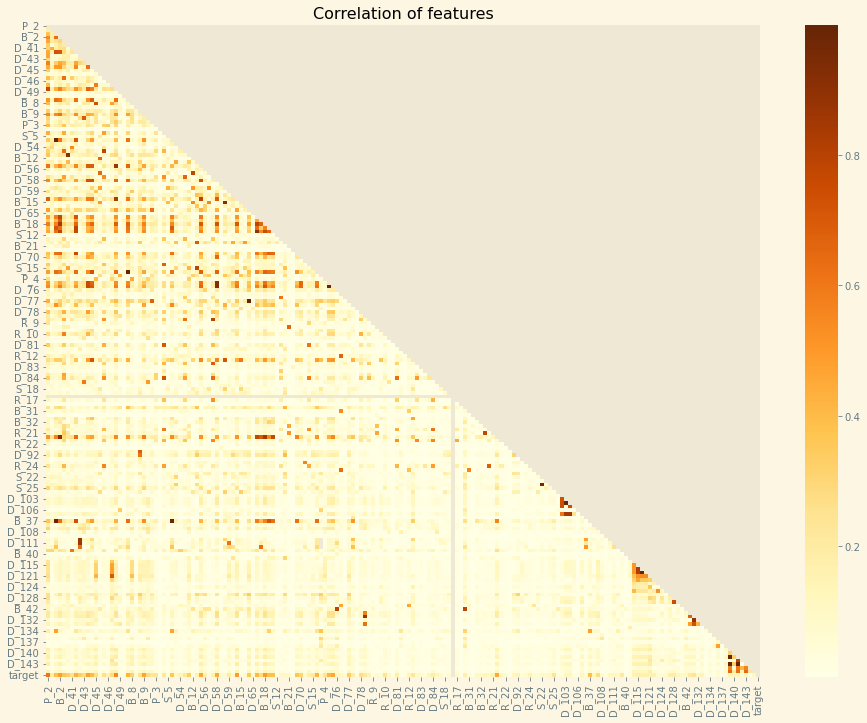

In [38]:
correlations = train_samples.corr().abs()

mask=np.triu(np.ones_like(correlations))

fig, ax = plt.subplots(1,1, figsize=(16,12))
sns.heatmap(correlations, ax=ax, mask=mask, cmap='YlOrBr')
ax.set_title("Correlation of features")
plt.show()

# 확인 시, 짙은 부분만 확인하면 되는데 디테일하게 확인하기 위해 아래 코드의 결과 확인

In [39]:
unstacked = correlations.unstack() # unstack 이 결과를 나누는.. 건가
unstacked = unstacked.sort_values(ascending=False, kind="quicksort").drop_duplicates().head(25)
unstacked 
# 상위 25개의 레코드를 보는데 이것은 상관관계가 높은 순서대로 나타냄

P_2    P_2      1.000000
D_62   D_77     0.999779
D_104  D_103    0.999749
D_143  D_139    0.999487
D_141  D_139    0.998175
D_143  D_141    0.997679
B_1    B_11     0.995384
B_23   B_7      0.995062
D_119  D_118    0.994899
B_37   B_1      0.993061
B_11   B_37     0.987895
D_74   D_75     0.987635
S_22   S_24     0.966566
D_58   D_75     0.926026
D_74   D_58     0.922519
B_14   B_15     0.915052
B_2    B_33     0.912541
S_7    S_3      0.903962
B_16   B_20     0.888432
D_132  D_131    0.886400
D_79   D_131    0.868602
D_42   D_110    0.868328
D_111  D_42     0.863704
D_55   D_48     0.862982
B_18   B_33     0.853254
dtype: float64

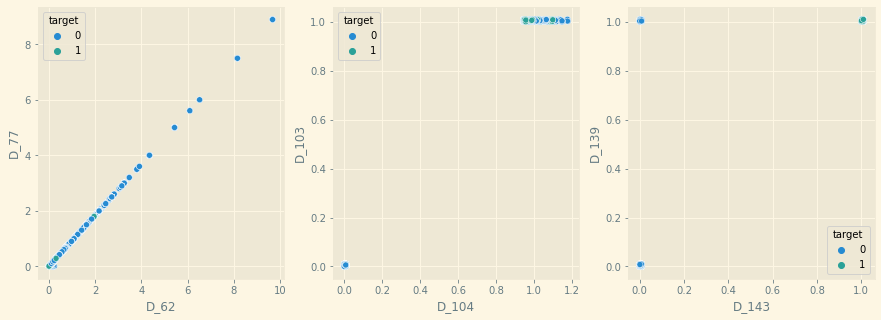

In [40]:
# unstacked.index[0]=1.0000 이니 제외하고 판단
x1, y1 = unstacked.index[1]
x2, y2 = unstacked.index[2]
x3, y3 = unstacked.index[3]

fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(x=x1, y=y1, data=train_samples, hue='target', ax=ax[0])
sns.scatterplot(x=x2, y=y2, data=train_samples, hue='target', ax=ax[1])
sns.scatterplot(x=x3, y=y3, data=train_samples, hue='target', ax=ax[2])
plt.show()

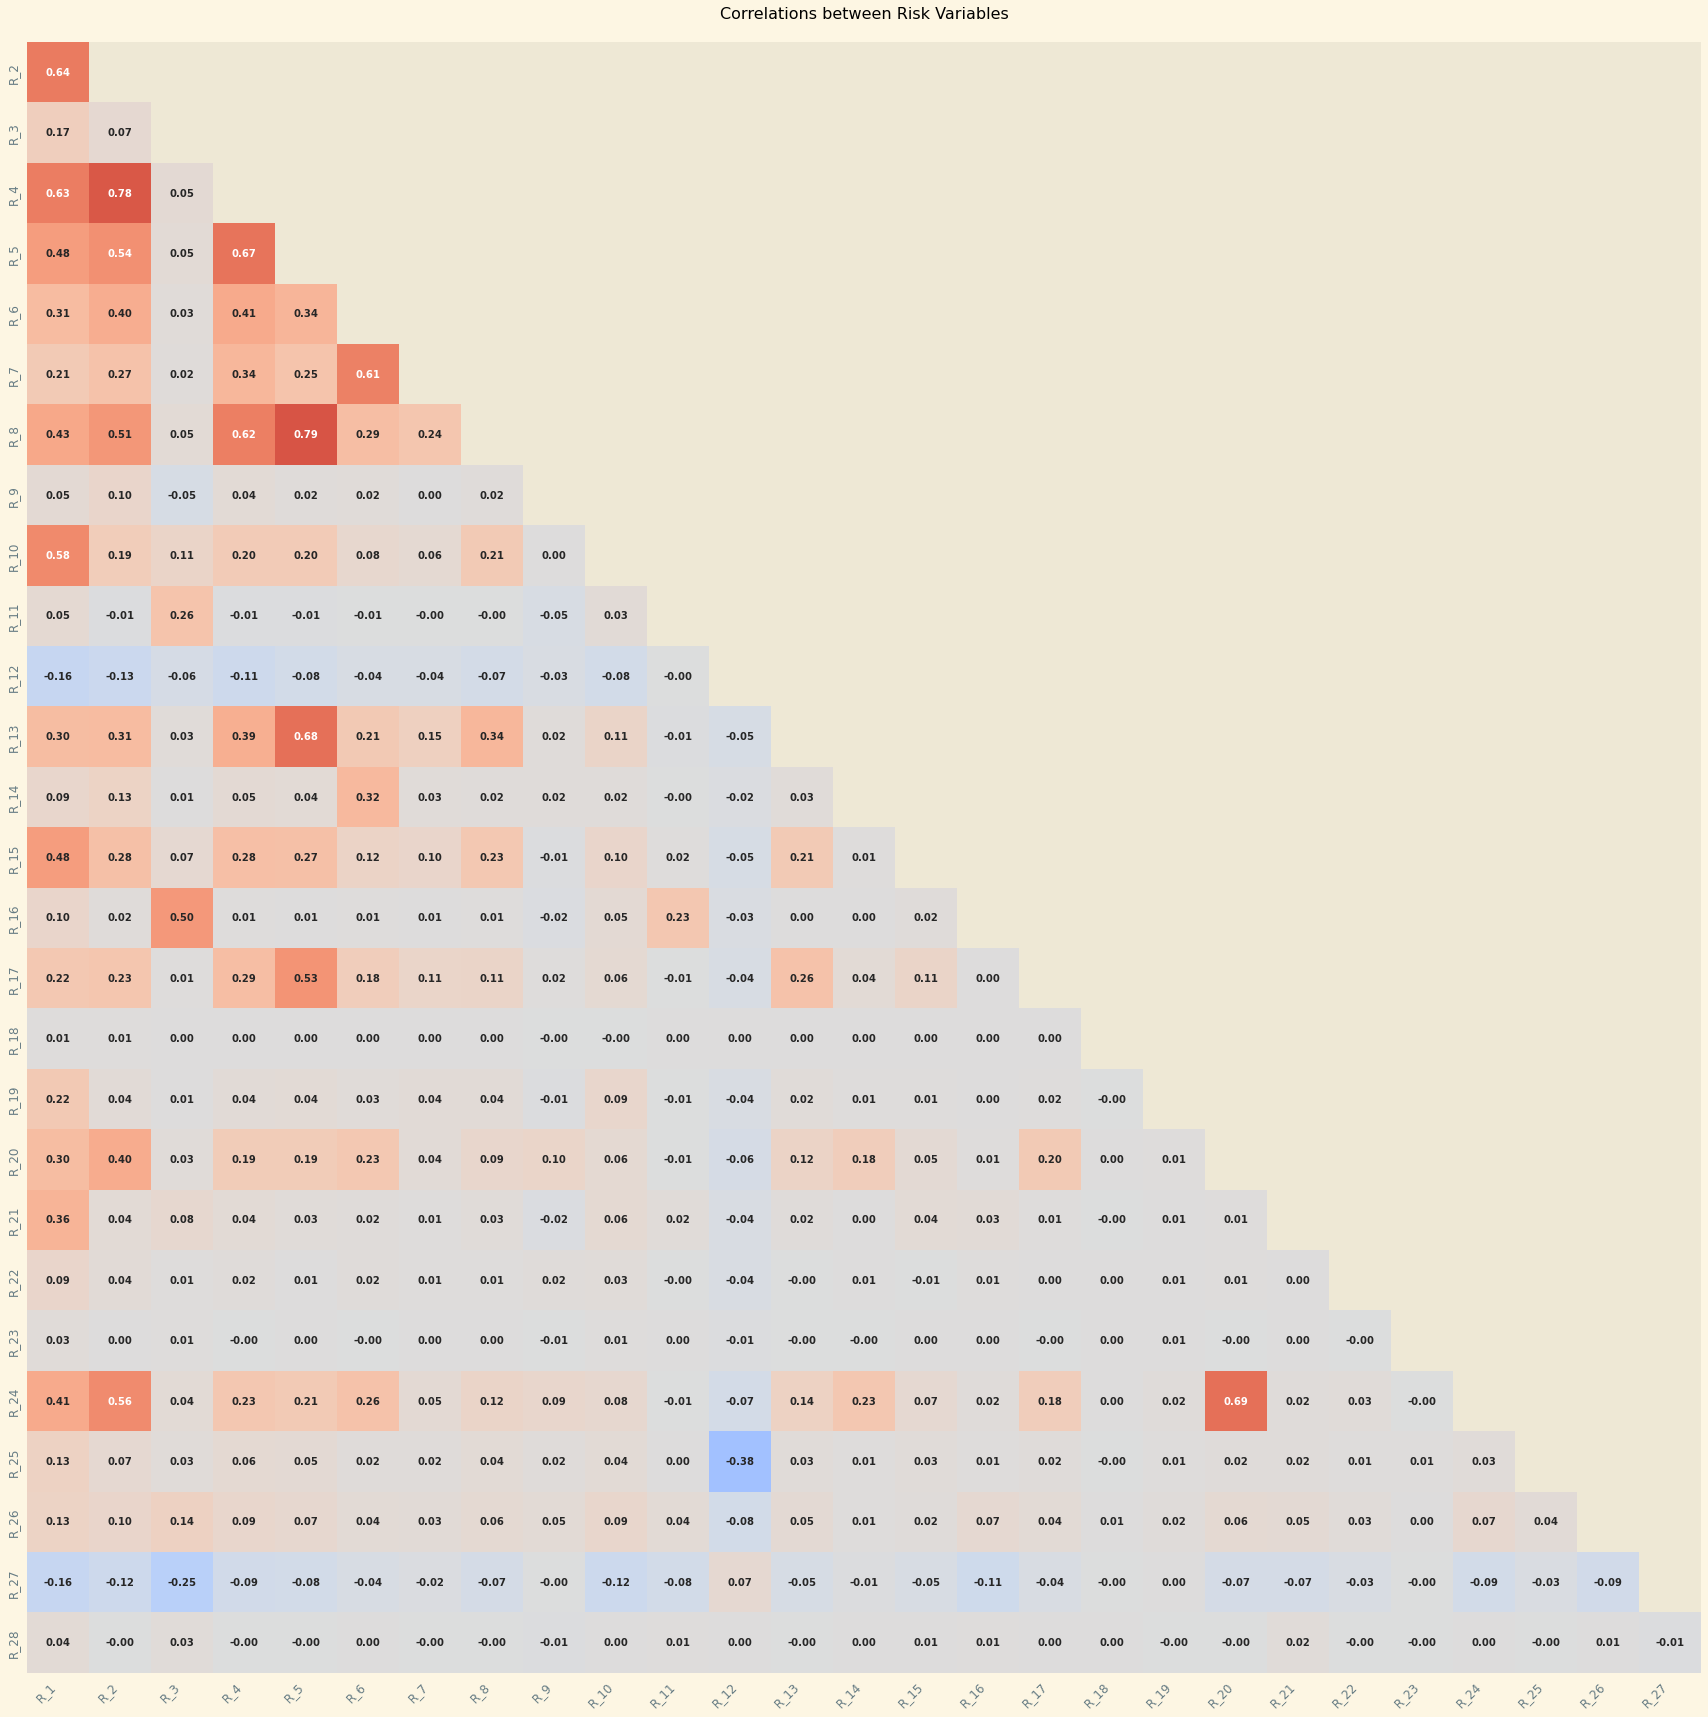

In [41]:
# code adapted from: https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols_to_show = [c for c in train_samples.columns if (c.startswith('R'))]
# r로 시작하는 cust에 대한 상관관계 확인

corr=train_samples[cols_to_show].corr()
mask=np.triu(np.ones_like(corr))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()

fig, ax = plt.subplots(figsize=(30,30))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Risk Variables\n', fontsize=16)
plt.show()

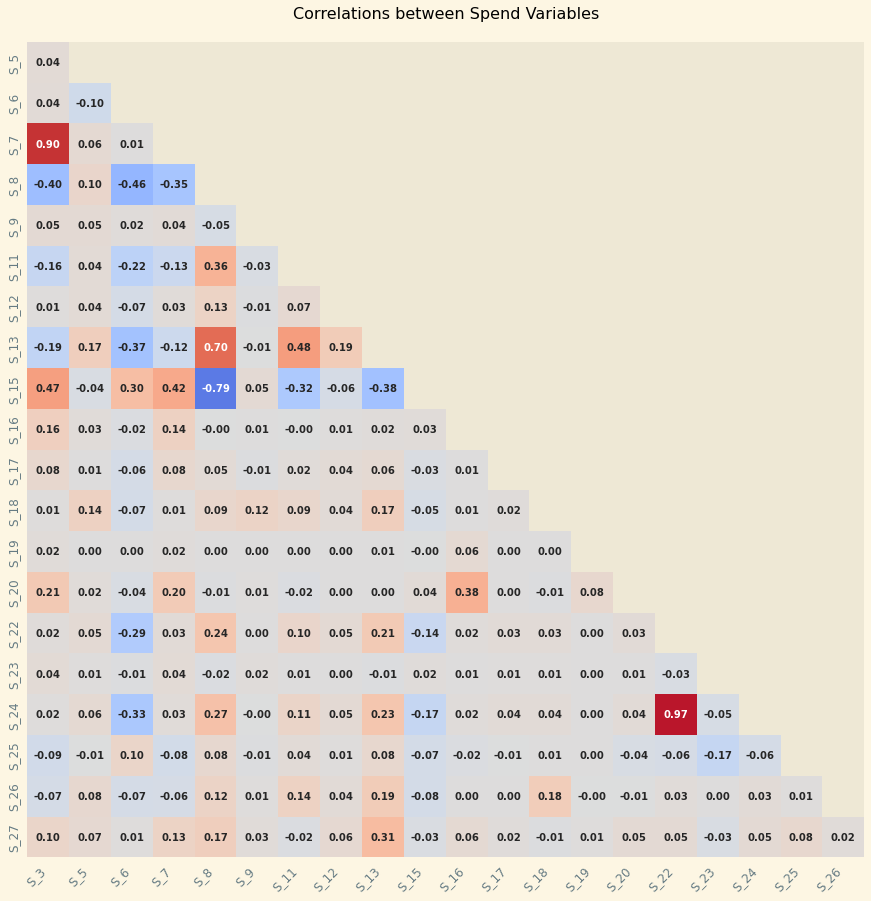

In [42]:
# code adapted from: https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols_to_show = [c for c in train_samples.columns if (c.startswith('S'))]
# s로 시작하는 cust에 대한 상관관계 확인

corr=train_samples[cols_to_show].corr()
mask=np.triu(np.ones_like(corr))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()

fig, ax = plt.subplots(figsize=(15,15))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
plt.show()

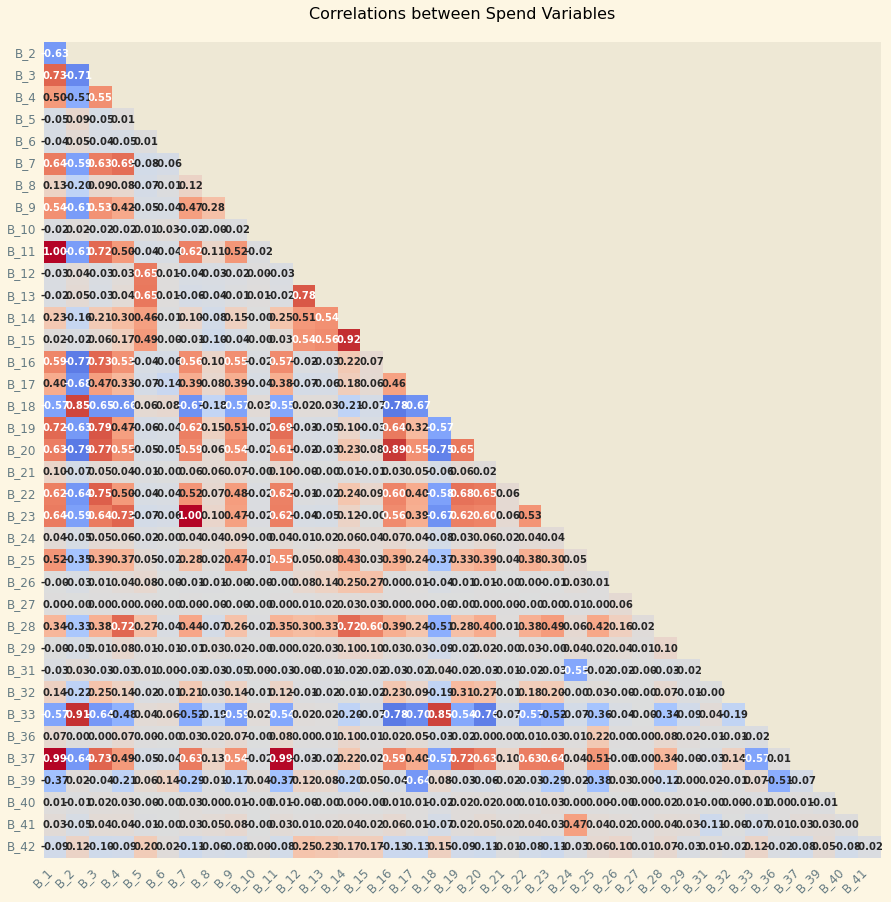

In [58]:
# code adapted from: https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols_to_show = [c for c in train_samples.columns if (c.startswith('B'))]
# b로 시작하는 cust에 대한 상관관계 확인

corr=train_samples[cols_to_show].corr()
mask=np.triu(np.ones_like(corr))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()

fig, ax = plt.subplots(figsize=(15,15))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
plt.show()

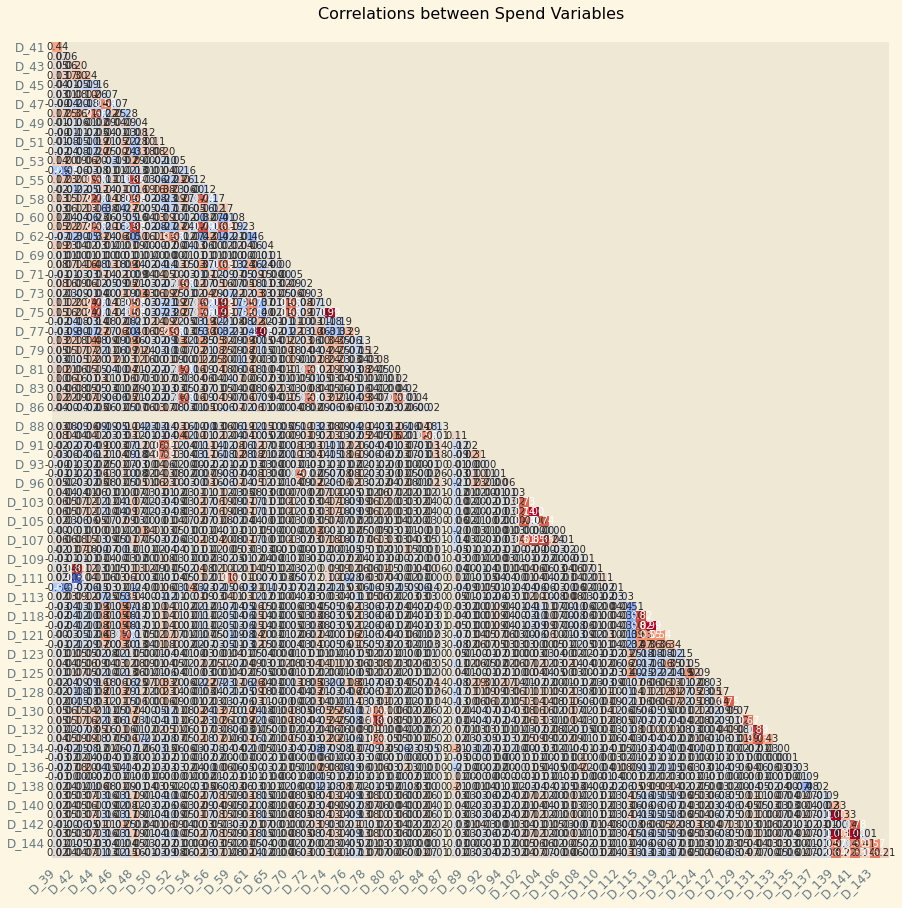

In [60]:
# code adapted from: https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols_to_show = [c for c in train_samples.columns if (c.startswith('D'))]
# d로 시작하는 cust에 대한 상관관계 확인

corr=train_samples[cols_to_show].corr()
mask=np.triu(np.ones_like(corr))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()

fig, ax = plt.subplots(figsize=(15,15))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
plt.show()

#### 각 변수마다 분포 확인

In [61]:

def show_kdeplots(letter, figsize):   
    cols = [c for c in train_samples.columns if (c.startswith((letter,'t'))) & (c not in categorical_features)]
    df_tmp = train_samples[cols]
    plt_cols = 5
    plt_rows = math.ceil(len(cols)/plt_cols)

    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=figsize)
    for i, ax in enumerate(axes.reshape(-1)):
        if i<len(cols)-1:
            sns.kdeplot(x=cols[i], hue='target', hue_order=[1,0], label=['Default','Paid'], data=df_tmp, 
                        fill=True, linewidth=2, legend=False, ax=ax)
        ax.tick_params(left=False, bottom=False, labelsize=5)
        ax.xaxis.get_label().set_fontsize(10)
        ax.set_ylabel('')

    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.show()

In [ ]:
show_kdeplots('D', (15,30))

In [ ]:
show_kdeplots('P', (15,5))

In [ ]:
show_kdeplots('S', (15,15))

In [ ]:
## 데이터 분포가 비대칭정도가 심함